In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


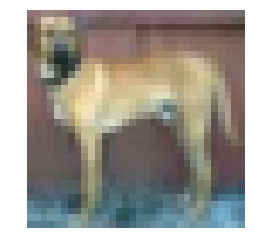

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [20]:
def conv_net_is_training_placeholder():
    return tf.placeholder(tf.bool)

In [21]:
def conv_net(inputs, keep_prob, is_training):   
    
    # Conv Layer - 1, Input 32x32x3 -> BatchNorm -> eLU -> MaxPooling -> Output 16x16x32
    conv1_layer = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=3, strides=1, 
                                   padding="SAME", activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_layer_norm = tf.layers.batch_normalization(conv1_layer, training=is_training)
    conv1_layer_activated = tf.nn.elu(conv1_layer_norm)
    conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer_activated, pool_size=2, strides=2)
    
    # Conv Layer - 2, Input 16x16x16 -> BatchNorm -> eLU -> MaxPooling -> Output 8x8x32
    conv2_layer = tf.layers.conv2d(inputs=conv1_layer_mpool, filters=48, kernel_size=3, strides=1, 
                                   padding="SAME", activation=None, 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_layer_norm = tf.layers.batch_normalization(conv2_layer, training=is_training)
    conv2_layer_activated = tf.nn.elu(conv2_layer_norm)
    conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer_activated, pool_size=2, strides=2)

    # Conv Layer - 3, Input 8x8x32 -> BatchNorm -> eLU -> MaxPooling -> Output 4x4x64
    conv3_layer = tf.layers.conv2d(inputs=conv2_layer_mpool, filters=64, kernel_size=3, strides=1,
                                   padding="SAME", activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_layer_norm = tf.layers.batch_normalization(conv3_layer, training=is_training)
    conv3_layer_activated = tf.nn.elu(conv3_layer_norm)
    conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer_activated, pool_size=2, strides=2)
    
    # Conv Layer Flattened
    conv_output_shape = conv3_layer_mpool.get_shape().as_list()
    flatten=tf.reshape(conv3_layer_mpool,
                       [-1, conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]])
    
    # Dense Layer - 1, Size 256 -> Dropout
    dense1_layer = tf.layers.dense(inputs=flatten, units=256, activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense1_layer_norm = tf.layers.batch_normalization(dense1_layer, training=is_training)
    dense1_layer_activated = tf.nn.elu(dense1_layer_norm)
    dense1_layer_dropout = tf.layers.dropout(dense1_layer_activated, rate=keep_prob)
    
    # Dense Layer - 2, Size 128 -> Dropout
    dense2_layer = tf.layers.dense(inputs=dense1_layer_dropout, units=128, activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense2_layer_norm = tf.layers.batch_normalization(dense2_layer, training=is_training)
    dense2_layer_activated = tf.nn.elu(dense2_layer_norm)
    dense2_layer_dropout = tf.layers.dropout(dense2_layer_activated, rate=keep_prob)
    
    # Output Layer 
    output = tf.layers.dense(inputs=dense2_layer_dropout, units=NUM_CLASSES, activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    return output

#### Batch utils

In [22]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [23]:
tf.reset_default_graph()

- Assemble model

In [24]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()
is_training = conv_net_is_training_placeholder()

model = conv_net(inputs, keep_prob, is_training)

- Cost function, training optimizer, correct predictions, accuracy

In [25]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer(0.0005).minimize(cost)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Hyperparameters

In [26]:
epochs = 150
keep_probability = 0.75
batch_size = 64

#### Training cycle

In [27]:
session = tf.Session()

In [28]:
session.run(tf.global_variables_initializer())

batch_count = 0
info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, 
                                          targets: label_batch,
                                          keep_prob: keep_probability,
                                          is_training: True})
        if (batch_count % 50) == 0:
            train_cost = session.run(cost, feed_dict={
                    inputs: data_batch, targets: label_batch, keep_prob: 1. ,is_training: False})

            train_acc = session.run(accuracy, feed_dict={
                inputs: data_batch, targets: label_batch, keep_prob: 1., is_training: False})

            info["train_cost"].append(train_cost)
            info["train_acc"].append(train_acc)

            valid_cost = session.run(cost, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1., is_training: False})

            valid_acc = session.run(accuracy, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1., is_training: False})

            info["valid_cost"].append(valid_cost)
            info["valid_acc"].append(valid_acc)

            print('Epoch {}, Batch {}:  '.format(epoch + 1, batch_count), end='')
            print("Train cost = ", "{:.4f},".format(train_cost), 
                  "Train acc = ", "{:.4f}".format(train_acc),
                  "Val cost = ", "{:.4f},".format(valid_cost), 
                  "Val acc = ", "{:.4f}".format(valid_acc))

Epoch 1, Batch 50:  Train cost =  2.5723, Train acc =  0.1406 Val cost =  2.6488, Val acc =  0.1032
Epoch 1, Batch 100:  Train cost =  2.8252, Train acc =  0.0938 Val cost =  2.7816, Val acc =  0.1035
Epoch 1, Batch 150:  Train cost =  3.2579, Train acc =  0.1094 Val cost =  3.2546, Val acc =  0.1033
Epoch 1, Batch 200:  Train cost =  2.8946, Train acc =  0.1094 Val cost =  2.7465, Val acc =  0.1181
Epoch 1, Batch 250:  Train cost =  2.9039, Train acc =  0.1719 Val cost =  2.4951, Val acc =  0.1666
Epoch 1, Batch 300:  Train cost =  2.2748, Train acc =  0.1562 Val cost =  2.5730, Val acc =  0.2186
Epoch 1, Batch 350:  Train cost =  2.4752, Train acc =  0.2656 Val cost =  2.2438, Val acc =  0.2580
Epoch 1, Batch 400:  Train cost =  1.5960, Train acc =  0.4219 Val cost =  1.7837, Val acc =  0.3772
Epoch 1, Batch 450:  Train cost =  1.3865, Train acc =  0.4531 Val cost =  1.5101, Val acc =  0.4613
Epoch 1, Batch 500:  Train cost =  1.5390, Train acc =  0.3906 Val cost =  1.5252, Val acc =

Epoch 7, Batch 4100:  Train cost =  0.5680, Train acc =  0.8281 Val cost =  1.0766, Val acc =  0.6537
Epoch 7, Batch 4150:  Train cost =  0.8754, Train acc =  0.7344 Val cost =  1.0662, Val acc =  0.6646
Epoch 7, Batch 4200:  Train cost =  0.7521, Train acc =  0.8125 Val cost =  0.8857, Val acc =  0.7046
Epoch 7, Batch 4250:  Train cost =  0.4648, Train acc =  0.8438 Val cost =  0.9162, Val acc =  0.6954
Epoch 7, Batch 4300:  Train cost =  0.3316, Train acc =  0.8750 Val cost =  0.8356, Val acc =  0.7181
Epoch 7, Batch 4350:  Train cost =  0.6753, Train acc =  0.7656 Val cost =  0.9820, Val acc =  0.6829
Epoch 8, Batch 4400:  Train cost =  0.5439, Train acc =  0.7812 Val cost =  0.9313, Val acc =  0.6953
Epoch 8, Batch 4450:  Train cost =  0.4033, Train acc =  0.9062 Val cost =  0.8398, Val acc =  0.7175
Epoch 8, Batch 4500:  Train cost =  0.4370, Train acc =  0.8594 Val cost =  0.9835, Val acc =  0.6876
Epoch 8, Batch 4550:  Train cost =  0.3958, Train acc =  0.8281 Val cost =  0.9688

Epoch 13, Batch 8100:  Train cost =  0.4101, Train acc =  0.8438 Val cost =  1.0187, Val acc =  0.7115
Epoch 14, Batch 8150:  Train cost =  0.2551, Train acc =  0.8906 Val cost =  1.1890, Val acc =  0.6881
Epoch 14, Batch 8200:  Train cost =  0.2003, Train acc =  0.9375 Val cost =  1.0479, Val acc =  0.7119
Epoch 14, Batch 8250:  Train cost =  0.1435, Train acc =  0.9688 Val cost =  0.9826, Val acc =  0.7276
Epoch 14, Batch 8300:  Train cost =  0.0987, Train acc =  0.9844 Val cost =  1.0070, Val acc =  0.7243
Epoch 14, Batch 8350:  Train cost =  0.3307, Train acc =  0.8594 Val cost =  1.1218, Val acc =  0.6994
Epoch 14, Batch 8400:  Train cost =  0.1724, Train acc =  0.9219 Val cost =  1.0560, Val acc =  0.7181
Epoch 14, Batch 8450:  Train cost =  0.3577, Train acc =  0.9062 Val cost =  1.1498, Val acc =  0.7024
Epoch 14, Batch 8500:  Train cost =  0.1710, Train acc =  0.9375 Val cost =  1.0784, Val acc =  0.7109
Epoch 14, Batch 8550:  Train cost =  0.1518, Train acc =  0.9219 Val cost

Epoch 20, Batch 12100:  Train cost =  0.0961, Train acc =  0.9844 Val cost =  1.2725, Val acc =  0.7084
Epoch 20, Batch 12150:  Train cost =  0.1909, Train acc =  0.9531 Val cost =  1.3671, Val acc =  0.6971
Epoch 20, Batch 12200:  Train cost =  0.0605, Train acc =  0.9688 Val cost =  1.3230, Val acc =  0.7177
Epoch 20, Batch 12250:  Train cost =  0.0739, Train acc =  0.9688 Val cost =  1.2736, Val acc =  0.7160
Epoch 20, Batch 12300:  Train cost =  0.0645, Train acc =  0.9688 Val cost =  1.2730, Val acc =  0.7190
Epoch 20, Batch 12350:  Train cost =  0.2186, Train acc =  0.9219 Val cost =  1.4747, Val acc =  0.6870
Epoch 20, Batch 12400:  Train cost =  0.2902, Train acc =  0.9062 Val cost =  1.6086, Val acc =  0.6757
Epoch 20, Batch 12450:  Train cost =  0.5158, Train acc =  0.7969 Val cost =  1.8398, Val acc =  0.6437
Epoch 20, Batch 12500:  Train cost =  0.1140, Train acc =  0.9531 Val cost =  1.3946, Val acc =  0.6996
Epoch 21, Batch 12550:  Train cost =  0.1477, Train acc =  0.937

Epoch 26, Batch 16050:  Train cost =  0.0339, Train acc =  1.0000 Val cost =  1.3406, Val acc =  0.7268
Epoch 26, Batch 16100:  Train cost =  0.0660, Train acc =  0.9688 Val cost =  1.3506, Val acc =  0.7178
Epoch 26, Batch 16150:  Train cost =  0.0183, Train acc =  1.0000 Val cost =  1.3206, Val acc =  0.7275
Epoch 26, Batch 16200:  Train cost =  0.0260, Train acc =  1.0000 Val cost =  1.3341, Val acc =  0.7271
Epoch 26, Batch 16250:  Train cost =  0.1872, Train acc =  0.9375 Val cost =  1.6410, Val acc =  0.6950
Epoch 27, Batch 16300:  Train cost =  0.0530, Train acc =  0.9844 Val cost =  1.4497, Val acc =  0.7094
Epoch 27, Batch 16350:  Train cost =  0.1951, Train acc =  0.9062 Val cost =  1.5773, Val acc =  0.7020
Epoch 27, Batch 16400:  Train cost =  0.0177, Train acc =  1.0000 Val cost =  1.3761, Val acc =  0.7201
Epoch 27, Batch 16450:  Train cost =  0.0294, Train acc =  1.0000 Val cost =  1.3456, Val acc =  0.7264
Epoch 27, Batch 16500:  Train cost =  0.0679, Train acc =  0.968

Epoch 32, Batch 20000:  Train cost =  0.0804, Train acc =  0.9688 Val cost =  1.8407, Val acc =  0.6755
Epoch 33, Batch 20050:  Train cost =  0.0375, Train acc =  1.0000 Val cost =  1.5077, Val acc =  0.7236
Epoch 33, Batch 20100:  Train cost =  0.2747, Train acc =  0.9062 Val cost =  1.6838, Val acc =  0.7033
Epoch 33, Batch 20150:  Train cost =  0.0225, Train acc =  0.9844 Val cost =  1.4937, Val acc =  0.7202
Epoch 33, Batch 20200:  Train cost =  0.0206, Train acc =  1.0000 Val cost =  1.4199, Val acc =  0.7253
Epoch 33, Batch 20250:  Train cost =  0.0245, Train acc =  1.0000 Val cost =  1.4588, Val acc =  0.7258
Epoch 33, Batch 20300:  Train cost =  0.0328, Train acc =  1.0000 Val cost =  1.3924, Val acc =  0.7333
Epoch 33, Batch 20350:  Train cost =  0.0660, Train acc =  1.0000 Val cost =  1.5536, Val acc =  0.7145
Epoch 33, Batch 20400:  Train cost =  0.0095, Train acc =  1.0000 Val cost =  1.5985, Val acc =  0.7114
Epoch 33, Batch 20450:  Train cost =  0.0296, Train acc =  1.000

Epoch 39, Batch 23950:  Train cost =  0.0748, Train acc =  0.9844 Val cost =  1.6693, Val acc =  0.7103
Epoch 39, Batch 24000:  Train cost =  0.0207, Train acc =  1.0000 Val cost =  1.6025, Val acc =  0.7170
Epoch 39, Batch 24050:  Train cost =  0.0861, Train acc =  0.9531 Val cost =  1.5340, Val acc =  0.7177
Epoch 39, Batch 24100:  Train cost =  0.0228, Train acc =  1.0000 Val cost =  1.5668, Val acc =  0.7237
Epoch 39, Batch 24150:  Train cost =  0.0283, Train acc =  0.9844 Val cost =  1.5579, Val acc =  0.7267
Epoch 39, Batch 24200:  Train cost =  0.1100, Train acc =  0.9531 Val cost =  1.6630, Val acc =  0.7135
Epoch 39, Batch 24250:  Train cost =  0.2372, Train acc =  0.9219 Val cost =  1.7857, Val acc =  0.6882
Epoch 39, Batch 24300:  Train cost =  0.2114, Train acc =  0.9375 Val cost =  1.7078, Val acc =  0.7179
Epoch 39, Batch 24350:  Train cost =  0.0834, Train acc =  0.9531 Val cost =  1.9017, Val acc =  0.6911
Epoch 40, Batch 24400:  Train cost =  0.0152, Train acc =  1.000

Epoch 45, Batch 27900:  Train cost =  0.0045, Train acc =  1.0000 Val cost =  1.5138, Val acc =  0.7318
Epoch 45, Batch 27950:  Train cost =  0.0198, Train acc =  0.9844 Val cost =  1.5989, Val acc =  0.7268
Epoch 45, Batch 28000:  Train cost =  0.0282, Train acc =  0.9844 Val cost =  1.5663, Val acc =  0.7298
Epoch 45, Batch 28050:  Train cost =  0.0855, Train acc =  0.9688 Val cost =  1.6063, Val acc =  0.7176
Epoch 45, Batch 28100:  Train cost =  0.0209, Train acc =  1.0000 Val cost =  1.6857, Val acc =  0.7125
Epoch 46, Batch 28150:  Train cost =  0.2812, Train acc =  0.9375 Val cost =  1.6339, Val acc =  0.7253
Epoch 46, Batch 28200:  Train cost =  0.1955, Train acc =  0.9531 Val cost =  1.6801, Val acc =  0.7151
Epoch 46, Batch 28250:  Train cost =  0.0225, Train acc =  1.0000 Val cost =  1.5675, Val acc =  0.7331
Epoch 46, Batch 28300:  Train cost =  0.0447, Train acc =  1.0000 Val cost =  1.6871, Val acc =  0.7239
Epoch 46, Batch 28350:  Train cost =  0.0059, Train acc =  1.000

Epoch 51, Batch 31850:  Train cost =  0.1118, Train acc =  0.9688 Val cost =  1.7638, Val acc =  0.7191
Epoch 52, Batch 31900:  Train cost =  0.0681, Train acc =  0.9688 Val cost =  1.6493, Val acc =  0.7230
Epoch 52, Batch 31950:  Train cost =  0.0238, Train acc =  1.0000 Val cost =  1.7269, Val acc =  0.7094
Epoch 52, Batch 32000:  Train cost =  0.0151, Train acc =  1.0000 Val cost =  1.6883, Val acc =  0.7238
Epoch 52, Batch 32050:  Train cost =  0.0301, Train acc =  0.9844 Val cost =  1.7298, Val acc =  0.7238
Epoch 52, Batch 32100:  Train cost =  0.0169, Train acc =  1.0000 Val cost =  1.6709, Val acc =  0.7186
Epoch 52, Batch 32150:  Train cost =  0.0204, Train acc =  0.9844 Val cost =  1.5952, Val acc =  0.7339
Epoch 52, Batch 32200:  Train cost =  0.0288, Train acc =  0.9844 Val cost =  1.6558, Val acc =  0.7288
Epoch 52, Batch 32250:  Train cost =  0.0800, Train acc =  0.9688 Val cost =  1.6720, Val acc =  0.7225
Epoch 52, Batch 32300:  Train cost =  0.0745, Train acc =  0.968

Epoch 58, Batch 35800:  Train cost =  0.0171, Train acc =  0.9844 Val cost =  1.6067, Val acc =  0.7275
Epoch 58, Batch 35850:  Train cost =  0.0461, Train acc =  0.9844 Val cost =  1.6547, Val acc =  0.7314
Epoch 58, Batch 35900:  Train cost =  0.0036, Train acc =  1.0000 Val cost =  1.6006, Val acc =  0.7354
Epoch 58, Batch 35950:  Train cost =  0.0401, Train acc =  0.9688 Val cost =  1.7908, Val acc =  0.7140
Epoch 58, Batch 36000:  Train cost =  0.0110, Train acc =  1.0000 Val cost =  1.6762, Val acc =  0.7298
Epoch 58, Batch 36050:  Train cost =  0.0739, Train acc =  0.9688 Val cost =  1.7949, Val acc =  0.7182
Epoch 58, Batch 36100:  Train cost =  0.0813, Train acc =  0.9844 Val cost =  1.7457, Val acc =  0.7147
Epoch 58, Batch 36150:  Train cost =  0.0237, Train acc =  0.9844 Val cost =  1.8295, Val acc =  0.7142
Epoch 58, Batch 36200:  Train cost =  0.0220, Train acc =  0.9844 Val cost =  1.7829, Val acc =  0.7219
Epoch 58, Batch 36250:  Train cost =  0.0549, Train acc =  0.968

KeyboardInterrupt: 

#### Results

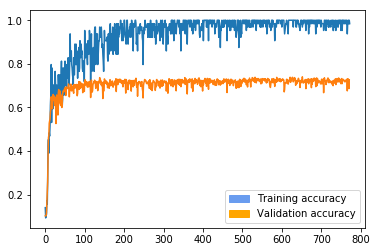

In [29]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

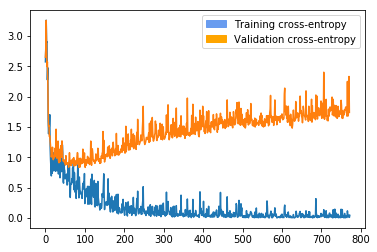

In [30]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [ ]:
test_acc = session.run(accuracy, feed_dict={
    inputs: test_data_norm, targets: test_labels_ohe, keep_prob: 1., is_training: False})
print("Test data accuracy: " + str(test_acc))

In [ ]:
session.close()